In [49]:
import torch
import torch.nn as nn
import pandas as pd

from tqdm.notebook import tqdm as tqdm_nb

from torch.autograd import Variable
import torch.autograd as autograd

import torch.optim as optim
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.utils as vutils
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.models import inception_v3

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device=torch.device("cuda")
else:
    device=torch.device("cpu")

#device=torch.device("cpu")
print(device)

mps


In [50]:
workers = 0
image_size = 64
batch_size=128

# Size of z latent vector 
nz = 100

#image size
img_s=64
# Number of channels in the training images. For color images this is 3
nc = 3

# Nubmer of loop to train ciritic
n_critics = 5


imageDir="./archive/data0/lsun/bedroom"

fixed_noise = torch.randn(64, nz, 1, 1, device=device)


In [51]:
dataset = datasets.ImageFolder(root=imageDir,
                                transform=T.Compose([
                                    T.Resize((img_s,img_s)),
                                    T.ToTensor(),
                                    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

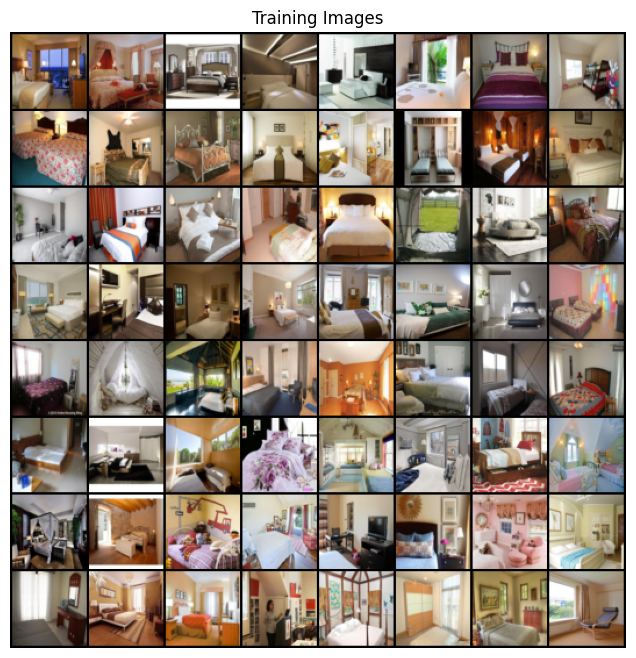

In [35]:
one_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(one_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [36]:
import math
def conv_out_size_same(size, stride):
  return int(math.ceil(float(size) / float(stride)))
s_h= img_s
s_h2 = conv_out_size_same(s_h, 2)
s_h4 = conv_out_size_same(s_h2, 2)
s_h8 = conv_out_size_same(s_h4, 2)
s_h16 = conv_out_size_same(s_h8, 2)

In [37]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.fc_bn_layer1 = nn.Sequential(nn.Linear(nz,s_h16*s_h16*8*img_s,bias=False),nn.BatchNorm1d(s_h16*s_h16*8*img_s))
    self.up_sample_layer2 = nn.Sequential(nn.ConvTranspose2d(img_s*8,img_s*4,4,stride=2,padding=1,bias=False),nn.BatchNorm2d(img_s*4,momentum=0.1,eps=1e-5))
    self.up_sample_layer3 = nn.Sequential(nn.ConvTranspose2d(img_s*4,img_s*2,4,stride=2,padding=1,bias=False),nn.BatchNorm2d(img_s*2,momentum=0.1,eps=1e-5))
    self.up_sample_layer4 = nn.Sequential(nn.ConvTranspose2d(img_s*2,img_s,4,stride=2,padding=1,bias=False),nn.BatchNorm2d(img_s,momentum=0.1,eps=1e-5))
    self.up_sample_layer5 = nn.ConvTranspose2d(img_s,3,4,stride=2,padding=1) 
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = F.relu(self.fc_bn_layer1(x))
    x = x.view(-1,img_s*8,s_h16,s_h16)
    x = F.relu(self.up_sample_layer2(x))
    x = F.relu(self.up_sample_layer3(x))
    x = F.relu(self.up_sample_layer4(x))
    x = self.tanh(self.up_sample_layer5(x))
    return x

In [38]:
class Critic(nn.Module):
  def __init__(self):
    super(Critic,self).__init__()
    self.down_sample_layer1 = nn.Conv2d(3,img_s,4,stride=2,padding=1)
    self.down_sample_layer2 = nn.Conv2d(img_s,2*img_s,4,stride=2,padding=1)
    self.down_sample_layer3 = nn.Conv2d(2*img_s,4*img_s,4,stride=2,padding=1)
    self.down_sample_layer4 = nn.Conv2d(4*img_s,8*img_s,4,stride=2,padding=1)
    self.fc_layer5 = nn.Linear(s_h16*s_h16*8*img_s,1)


  def forward(self, x):
    x = F.leaky_relu(self.down_sample_layer1(x),0.2)
    x = F.leaky_relu(self.down_sample_layer2(x),0.2)
    x = F.leaky_relu(self.down_sample_layer3(x),0.2)
    x = F.leaky_relu(self.down_sample_layer4(x),0.2)
    x = x.flatten(1)
    x = self.fc_layer5(x)
    return x
     

In [39]:
learning_rate = 0.0001
beta1=0.5
beta2=0.9

gp_lambda = 10

G = Generator().to(device)
fw = Critic().to(device)

G_optimizer = optim.Adam(G.parameters(),lr=learning_rate,betas=(beta1,beta2))
critic_optimizer = optim.Adam(fw.parameters(),lr=learning_rate,betas=(beta1,beta2))

L2_criterion = nn.MSELoss()

fixed_noise = torch.randn(batch_size, nz,device=device)
     

In [40]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv')!=-1:
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('Norm')!=-1:
    nn.init.normal_(m.weight.data,1.0,0.02)

print(G.apply(weights_init))
print(fw.apply(weights_init))

Generator(
  (fc_bn_layer1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=False)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up_sample_layer2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up_sample_layer3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up_sample_layer4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up_sample_layer5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (tanh): Tanh()
)
Critic(
 

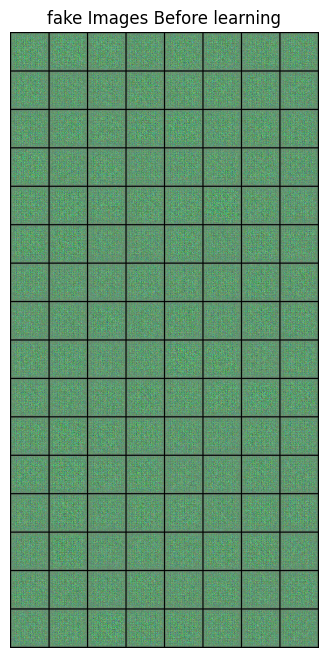

In [41]:
with torch.no_grad():
  fake_batch=G(fixed_noise)
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('fake Images Before learning')
plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device).view(batch_size,3,img_s,img_s),padding=2, normalize=True).cpu(),(1,2,0)))

In [22]:
num_epochs=3

In [23]:
#for mac os fix 
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [24]:
from scipy.linalg import sqrtm
from numpy import cov
from numpy import iscomplexobj
from numpy import trace

# calculate frechet inception distance
def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [26]:
img_list = []

G_losses = []
critic_losses = []

w_losses = []
gp_losses =[]
FIDval=[]

total_steps = num_epochs * len(dataloader)
fig_save_interval = total_steps // 20  # animation can contain max 36 images

pbar = tqdm_nb()
piter = 0

preprocess = torch.nn.Sequential(
    torch.nn.Upsample(size=(299, 299), mode='bilinear', align_corners=False),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

inception = inception_v3(pretrained=True).to(device).eval()

#checkpoint = SaveCheckpoint()

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    #print("Epoch: " +str(epoch))
    # For each batch in the dataloader
    pbar.reset(total=len(dataloader))
    with torch.no_grad():
        test = next(iter(dataloader))
        b_size = test[0].shape[0]
        real_img = test[0].to(device)

        real_images = preprocess(real_img)
        real_features = inception(real_images).view(real_images.shape[0], -1).cpu().detach().numpy()

        fakeFid = G(torch.randn(b_size, nz, device=device))

        generated_images = preprocess(fakeFid)
        generated_features = inception(generated_images).view(generated_images.shape[0], -1).cpu().detach().numpy()

        # Calculate the FID score
        fid_value = calculate_fid(real_features, generated_features)
        print("FID: "+str(fid_value))
        FIDval.append(fid_value)
    G.train()
    fw.train()
    for i, data in enumerate(dataloader, 0):
        pbar.update()
        piter += 1
        
        b_size = data[0].shape[0]
        real_img = data[0].to(device)
        
        noise = torch.randn(b_size, nz, device=device)

        fake_img = G(noise)
        
        alpha = torch.rand([b_size,1,1,1],device=device)#for sampling_distribution
        alpha = alpha.expand(real_img.size())

        fw.zero_grad()
        
        interpolates = alpha * real_img.data  + (1-alpha)*fake_img.data
        
        interpolates=Variable(interpolates,requires_grad=True)

        disc_interpolates= fw(interpolates)

        gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size(),device=device),
                                  create_graph=True)[0].view(interpolates.size(0),-1)
        slopes = gradients.norm(2,dim=1)
        lipschitz_gradient_norm=torch.ones(slopes.size(),device=device)
    
        loss_gp = gp_lambda*L2_criterion(slopes,lipschitz_gradient_norm)
    
        real_critic = fwx = fw(real_img)
        fake_critic = fwg = fw(fake_img.detach())
        loss_w = -(fwx.mean()-fwg.mean())

        loss_critic = loss_w + loss_gp
        
        loss_critic.backward()
        critic_optimizer.step()

        
        #Train G
        if i%n_critics==0:
            G.zero_grad()
            fwg = fw(fake_img)
      
            loss_G = -fwg.mean()

            loss_G.backward()
            G_optimizer.step()

            
            desc = '[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' \
                    % (epoch+1, num_epochs, i, len(dataloader), loss_critic.item(), fake_critic.mean().item())
            pbar.set_description(desc)


            G_losses.append(fake_critic.mean().item())
            critic_losses.append(loss_critic.item())

            w_losses.append(loss_w.item())
            gp_losses.append(loss_gp.item())

        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (piter - 1) % fig_save_interval == 0:
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()               
                
            img_list.append((epoch+1, i, vutils.make_grid(fake, padding=2, normalize=True)))
            print(desc)

        

pbar.refresh()

0it [00:00, ?it/s]

Starting Training Loop...
FID: 1484.1886210894215
[1/3][0/2369] Loss_D: 9.9851 Loss_G: -0.0281
[1/3][355/2369] Loss_D: -1.9839 Loss_G: 0.5284
[1/3][710/2369] Loss_D: -10.3967 Loss_G: -1.9627
[1/3][1065/2369] Loss_D: -9.3028 Loss_G: 0.1934


KeyboardInterrupt: 

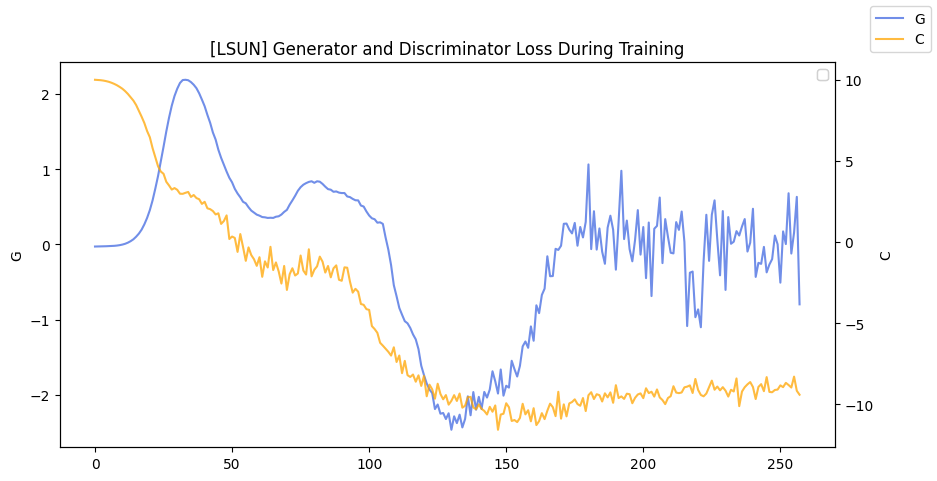

In [28]:
plt.figure(figsize=(10, 5))
plt.title("[LSUN] Generator and Discriminator Loss During Training")
df = pd.DataFrame({'G': G_losses, 'C': critic_losses})
ax1 = sns.lineplot(data=df, x=df.index, y='G', label='G', color='royalblue', alpha=.75)
ax2 = ax1.twinx()
sns.lineplot(data=df, x=df.index, y='C', label='C', color='orange', alpha=.75, ax=ax2)
for ax in [ax1, ax2]:
#     ax.set_ylim(bottom=0.)
    ax.legend([])
ax1.figure.legend()
plt.show()

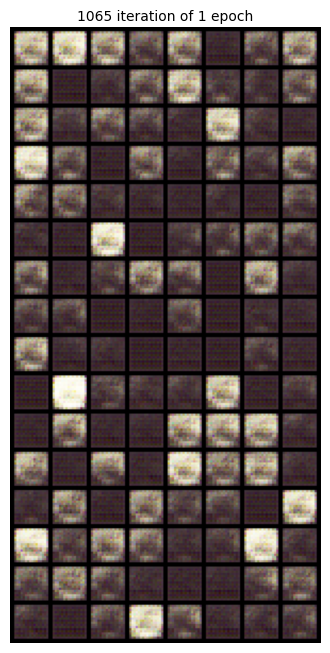

In [29]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.axis('off')
imgs = [[
    plt.imshow(np.transpose(img, (1,2,0)), animated=True),
    plt.text(0.5, 1.01, f'{step} iteration of {epoch} epoch', horizontalalignment='center', transform=ax.transAxes),
] for epoch, step, img in img_list]

ani = animation.ArtistAnimation(fig, imgs, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

DCGAN

In [52]:
class DC_Generator(nn.Module):
    def __init__(self):
        super(DC_Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, img_s * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(img_s * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(img_s * 8, img_s * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_s * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( img_s * 4, img_s * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_s* 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( img_s * 2, img_s, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_s),
            nn.ReLU(True),
            nn.ConvTranspose2d( img_s, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [53]:
class DC_Discriminator(nn.Module):
    def __init__(self):
        super(DC_Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, img_s, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(img_s, img_s * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_s * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(img_s* 2, img_s * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_s* 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(img_s* 4, img_s * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_s * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(img_s * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [54]:
netG =DC_Generator().to(device)
netD=DC_Discriminator().to(device)

In [55]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv')!=-1:
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('Norm')!=-1:
    nn.init.normal_(m.weight.data,1.0,0.02)

print(netG.apply(weights_init))
print(netD.apply(weights_init))

DC_Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )

In [56]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

learning_rate = 0.0001
beta1=0.5
beta2=0.9

gp_lambda = 10
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, beta2))

In [59]:
# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
FIDval=[]

iters = 0
num_epochs=1
total_steps = num_epochs * len(dataloader)
fig_save_interval = total_steps // 20  # animation can contain max 36 images

pbar = tqdm_nb()
pbar.refresh()

piter = 0

preprocess = torch.nn.Sequential(
    torch.nn.Upsample(size=(299, 299), mode='bilinear', align_corners=False),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

inception = inception_v3(pretrained=True).to(device).eval()

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    pbar.reset(total=len(dataloader))
    with torch.no_grad():
        test = next(iter(dataloader))
        b_size = test[0].shape[0]
        real_img = test[0].to(device)

        real_images = preprocess(real_img)
        real_features = inception(real_images).view(real_images.shape[0], -1).cpu().detach().numpy()

        fakeFid = netG(torch.randn(b_size, nz,1,1, device=device))
        generated_images = preprocess(fakeFid)
        generated_features = inception(generated_images).view(generated_images.shape[0], -1).cpu().detach().numpy()

        # Calculate the FID score
        fid_value = calculate_fid(real_features, generated_features)
        print("FID: "+str(fid_value))
        FIDval.append(fid_value)
    netG.train()
    netD.train()
    for i, data in enumerate(dataloader, 0):
        pbar.update()
        piter += 1

        b_size = data[0].shape[0]
        real_img = data[0].to(device)
        
        noise = torch.randn(b_size, nz,1,1, device=device)

        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        netD.zero_grad()
        output = netD(real_img).view(-1)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()


        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
            # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
            # Update G
        optimizerG.step()
        desc='[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'\
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2)
            
        pbar.set_description(desc)

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Output training stats
        if (piter - 1) % fig_save_interval == 0:
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()

            pbar.set_description(desc)

        
        # Save Losses for plotting later

        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()

            img_list.append((epoch+1, i, vutils.make_grid(fake, padding=2, normalize=True)))
pbar.refresh()            


0it [00:00, ?it/s]

Starting Training Loop...
FID: 1511.0031045918224


True

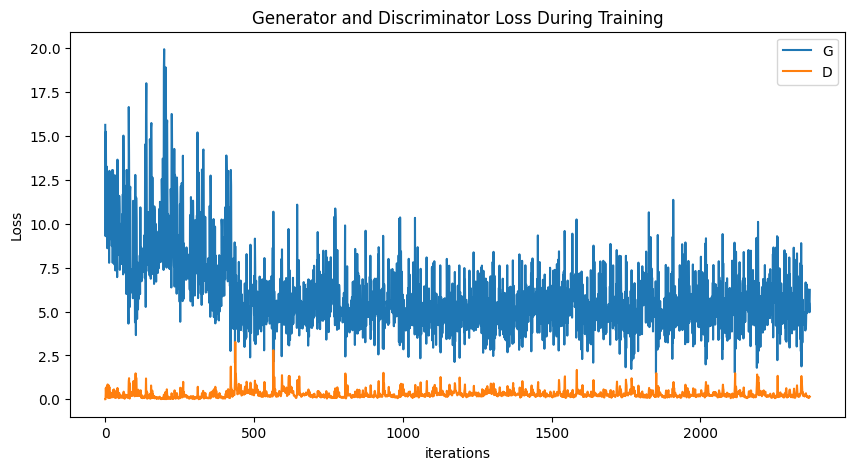

In [60]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [65]:
img_list[1]

(1,
 1,
 tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4296,  ..., 0.4615, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.3778,  ..., 0.4336, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4007,  ..., 0.4157, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.4496,  ..., 0.3463, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.384

In [1]:

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.axis('off')
imgs = [[
    plt.imshow(np.transpose(img, (1,2,0)), animated=True),
    plt.text(0.5, 1.01, f'{step} iteration of {epoch} epoch', horizontalalignment='center', transform=ax.transAxes),
]  for epoch, step, img in img_list if step %5 ==0]

ani = animation.ArtistAnimation(fig, imgs, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

NameError: name 'plt' is not defined

Generate two images and two latent vectors to comapre results

In [57]:
def linearInter(v1,v2,coeff):
    v3=torch.zeros((1,v1.shape[1]),device=device)
    for i in range(v1.shape[1]):
        v3[0][i]=v1[0][i]*(1-coeff)+v2[0][i]*coeff
    return v3

In [76]:
import random
G.eval()
Laten=[]
Images=[]
Laten.append(torch.randn(1,nz, device=device))
Laten.append(torch.randn(1,nz, device=device))
Images.append(G(Laten[0]))
Images.append(G(Laten[1]))

for i in range(2,10):
    coeff=random.random()
    Laten.append(linearInter(Laten[0],Laten[1],coeff))
    Images.append(G(Laten[i]))
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

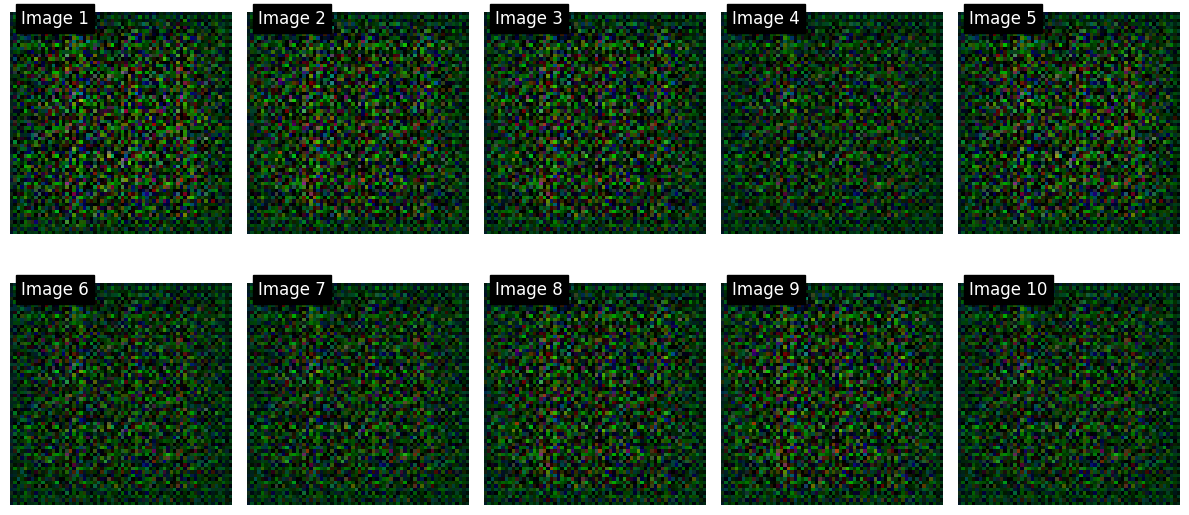

In [78]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i, image in enumerate(Images):
    ax = axs[i // 5, i % 5]
    image = image.squeeze().detach().numpy()
    image = np.transpose(image, (1, 2, 0))
    ax.imshow(image)
    ax.axis('off')
    ax.annotate(f'Image {i+1}', xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=12, color='white', backgroundcolor='black')

plt.tight_layout()
plt.show()
    
